In [36]:
import awswrangler as wr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys

In [2]:
repo_name = "mercury-pipeline-metaapi-sam"
sys.path.append(os.getcwd().split(repo_name)[0] + repo_name + "/lambda") 

In [3]:
import app

In [4]:
import random
import string

In [5]:
def apply_id(
    df: pd.DataFrame,
    label: str
) -> pd.DataFrame:
    mask = df[label] != 0.0
    df[label] = np.nan
    df.loc[mask, label] = "".join(random.choices(string.ascii_uppercase, k=20))
    return df

def ema(
    df: pd.DataFrame
) -> pd.DataFrame:
    
    for av in [1, 10, 21, 50]:
        df[f"ema_{av}"] = df["ask.close"].ewm(span=av, adjust=False).mean()
        
    # up and downtrends
    df["ema_up"] = (df["ema_10"] > df["ema_21"]) & (df["ema_10"] > df["ema_50"])
    df["ema_dn"] = (df["ema_10"] < df["ema_21"]) & (df["ema_10"] < df["ema_50"])
    
    df["ema_up_start"] = df["ema_up"] > df["ema_up"].shift()
    df["ema_dn_start"] = df["ema_dn"] > df["ema_dn"].shift()
    df["ema_up_stop"] = df["ema_up"] < df["ema_up"].shift()
    df["ema_dn_stop"] = df["ema_dn"] < df["ema_dn"].shift()
    
    df["ema_up"] = df["ema_up"] | df["ema_up_stop"]
    df["ema_dn"] = df["ema_dn"] | df["ema_dn_stop"]

    # Get a unique index for each individual trend
    df["ema_up_i"] = df["ema_up_start"].cumsum() * df["ema_up"]
    df["ema_dn_i"] = df["ema_dn_start"].cumsum() * df["ema_dn"]

    df = df.groupby("ema_up_i").apply(apply_id, label="ema_up_i")
    df = df.groupby("ema_dn_i").apply(apply_id, label="ema_dn_i")

    return df

In [86]:
def trend_properties_micro(
    df: pd.DataFrame,
    trend_type: str
) -> pd.DataFrame:
    # Make sure that points are in time order (they should be anyway but hey ho).
    df = (
        df.sort_values(by="timestamp_utc.open", ascending=True)
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index":f"trend_{trend_type}_idx"})
        .drop(columns=[f"ema_{trend_type}_i"])
    )
    
    i_peak = {
        "up": df.iloc[1:]["bid.high"].idxmax(),
        "dn": df.iloc[1:]["ask.low"].idxmin()
    }[trend_type]
    df[f"ema_{trend_type}_peak"] = i_peak
    
    df[f"ema_{trend_type}_profit"] = np.nan
    mask = df[f"trend_{trend_type}_idx"] > 0
    mask = mask & (df[f"trend_{trend_type}_idx"] <= i_peak)
    df.loc[mask, f"ema_{trend_type}_profit"] = {
        "up": df.iloc[i_peak]["bid.high"] - df.loc[mask]["ask.open"],
        "dn": df.loc[mask]["bid.open"] - df.iloc[i_peak]["ask.low"],
    }[trend_type]
    
    i_entry = df[f"ema_{trend_type}_profit"].idxmax(skipna=True)
    df[f"ema_{trend_type}_entry"] = i_entry
    
    return df[[
        "timestamp_utc.open",
        f"trend_{trend_type}_idx",
        f"ema_{trend_type}_peak",
        f"ema_{trend_type}_profit",
        f"ema_{trend_type}_entry",
    ]]

In [19]:
def trend_micro(
    df: pd.DataFrame
) -> pd.DataFrame:
    
    n_start = len(df)
    
    mask = df["ema_up"] == 1
    if len(df[mask]) > 0:
        dfi = (
            df[mask].groupby("ema_up_i")
            .apply(trend_properties_micro, trend_type="up")
            .reset_index()
            .drop(columns=["level_1"])
        )
        df = pd.merge(
            df,
            dfi,
            how="left",
            on=["timestamp_utc.open", "ema_up_i"]
        )
        
    mask = df["ema_dn"] == 1
    if len(df[mask]) > 0:
        dfi = (
            df[mask].groupby("ema_dn_i")
            .apply(trend_properties_micro, trend_type="dn")
            .reset_index()
            .drop(columns=["level_1"])
        )
        df = pd.merge(
            df,
            dfi,
            how="left",
            on=["timestamp_utc.open", "ema_dn_i"]
        )
        
    df = df.sort_values(by="timestamp_utc.open")
    assert len(df) == n_start
    return df

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
path = "s3://datalake.dgriffiths.io/projects/mercury/data/clean/candles/ffill/symbol=EURUSD/frequency=1T/year=2022/month=07/date=20220714/"

In [10]:
df = wr.s3.read_parquet(path, dataset=True)

In [11]:
df = ema(df)

In [12]:
df.head(3)

,timestamp_utc.open,ask.open,ask.close,ask.low,ask.high,n_ticks,bid.open,bid.close,bid.low,bid.high,ask.idx_hi_lo,bid.idx_hi_lo,timestamp_utc.close,timestamp_uk.open,timestamp_uk.close,symbol,frequency,year,month,date,hour,ema_1,ema_10,ema_21,ema_50,ema_up,ema_dn,ema_up_start,ema_dn_start,ema_up_stop,ema_dn_stop,ema_up_i,ema_dn_i
0,2022-07-14 00:00:00,1.00352,1.00342,1.00324,1.00364,85,1.00331,1.00323,1.00305,1.00345,hi,hi,2022-07-14 00:01:00,2022-07-14 01:00:00,2022-07-14 01:01:00,EURUSD,1T,2022,07,20220714,00,1.00342,1.003420,1.003420,1.003420,False,False,False,False,False,False,NaN,NaN
1,2022-07-14 00:01:00,1.00343,1.00373,1.00323,1.00376,88,1.00323,1.00354,1.00304,1.00357,lo,lo,2022-07-14 00:02:00,2022-07-14 01:01:00,2022-07-14 01:02:00,EURUSD,1T,2022,07,20220714,00,1.00373,1.003476,1.003448,1.003432,True,False,True,False,False,False,CYBJTFMEOJDMPCOEEIVD,NaN
2,2022-07-14 00:02:00,1.00376,1.00360,1.00360,1.00391,67,1.00357,1.00341,1.00341,1.00372,hi,hi,2022-07-14 00:03:00,2022-07-14 01:02:00,2022-07-14 01:03:00,EURUSD,1T,2022,07,20220714,00,1.00360,1.003499,1.003462,1.003439,True,False,False,False,False,False,CYBJTFMEOJDMPCOEEIVD,NaN


In [87]:
df_trend = df[df["ema_up_i"] == df["ema_up_i"].dropna().unique()[0]]
df_trend = trend_properties_micro(
    df_trend,
    "up"
)
df_trend

,timestamp_utc.open,trend_up_idx,ema_up_peak,ema_up_profit,ema_up_entry
0,2022-07-14 00:01:00,0,10,NaN,2
1,2022-07-14 00:02:00,1,10,0.00049,2
2,2022-07-14 00:03:00,2,10,0.00063,2
3,2022-07-14 00:04:00,3,10,0.00047,2
4,2022-07-14 00:05:00,4,10,0.00029,2
5,2022-07-14 00:06:00,5,10,0.00019,2
6,2022-07-14 00:07:00,6,10,0.00013,2
7,2022-07-14 00:08:00,7,10,0.00008,2
8,2022-07-14 00:09:00,8,10,0.00038,2
9,2022-07-14 00:10:00,9,10,-0.00002,2


In [67]:
df_out = trend_micro(df)
df_out

,timestamp_utc.open,ask.open,ask.close,ask.low,ask.high,n_ticks,bid.open,bid.close,bid.low,bid.high,ask.idx_hi_lo,bid.idx_hi_lo,timestamp_utc.close,timestamp_uk.open,timestamp_uk.close,symbol,frequency,year,month,date,hour,ema_1,ema_10,ema_21,ema_50,ema_up,ema_dn,ema_up_start,ema_dn_start,ema_up_stop,ema_dn_stop,ema_up_i,ema_dn_i,trend_up_idx,ema_up_peak,ema_up_profit,trend_dn_idx,ema_dn_peak,ema_dn_profit
0,2022-07-14 00:00:00,1.00352,1.00342,1.00324,1.00364,85,1.00331,1.00323,1.00305,1.00345,hi,hi,2022-07-14 00:01:00,2022-07-14 01:00:00,2022-07-14 01:01:00,EURUSD,1T,2022,07,20220714,00,1.00342,1.003420,1.003420,1.003420,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-07-14 00:01:00,1.00343,1.00373,1.00323,1.00376,88,1.00323,1.00354,1.00304,1.00357,lo,lo,2022-07-14 00:02:00,2022-07-14 01:01:00,2022-07-14 01:02:00,EURUSD,1T,2022,07,20220714,00,1.00373,1.003476,1.003448,1.003432,True,False,True,False,False,False,CYBJTFMEOJDMPCOEEIVD,NaN,0.0,10.0,<NA>,NaN,NaN,NaN
2,2022-07-14 00:02:00,1.00376,1.00360,1.00360,1.00391,67,1.00357,1.00341,1.00341,1.00372,hi,hi,2022-07-14 00:03:00,2022-07-14 01:02:00,2022-07-14 01:03:00,EURUSD,1T,2022,07,20220714,00,1.00360,1.003499,1.003462,1.003439,True,False,False,False,False,False,CYBJTFMEOJDMPCOEEIVD,NaN,1.0,10.0,0.00049,NaN,NaN,NaN
3,2022-07-14 00:03:00,1.00362,1.00374,1.00362,1.00386,72,1.00341,1.00355,1.00341,1.00367,lo,lo,2022-07-14 00:04:00,2022-07-14 01:03:00,2022-07-14 01:04:00,EURUSD,1T,2022,07,20220714,00,1.00374,1.003543,1.003487,1.003451,True,False,False,False,False,False,CYBJTFMEOJDMPCOEEIVD,NaN,2.0,10.0,0.00063,NaN,NaN,NaN
4,2022-07-14 00:04:00,1.00378,1.00394,1.00370,1.00402,54,1.00355,1.00375,1.00351,1.00383,lo,lo,2022-07-14 00:05:00,2022-07-14 01:04:00,2022-07-14 01:05:00,EURUSD,1T,2022,07,20220714,00,1.00394,1.003615,1.003528,1.003470,True,False,False,False,False,False,CYBJTFMEOJDMPCOEEIVD,NaN,3.0,10.0,0.00047,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2022-07-14 23:55:00,1.00258,1.00253,1.00247,1.00258,36,1.00235,1.00230,1.00224,1.00235,hi,hi,2022-07-14 23:56:00,2022-07-15 00:55:00,2022-07-15 00:56:00,EURUSD,1T,2022,07,20220714,23,1.00253,1.002507,1.002402,1.002230,True,False,False,False,False,False,BCSSKKJGNZGYGPAQZDVX,NaN,24.0,28.0,-0.00003,NaN,NaN,NaN
1436,2022-07-14 23:56:00,1.00254,1.00254,1.00253,1.00254,11,1.00230,1.00231,1.00230,1.00231,hi,lo,2022-07-14 23:57:00,2022-07-15 00:56:00,2022-07-15 00:57:00,EURUSD,1T,2022,07,20220714,23,1.00254,1.002513,1.002414,1.002242,True,False,False,False,False,False,BCSSKKJGNZGYGPAQZDVX,NaN,25.0,28.0,0.00001,NaN,NaN,NaN
1437,2022-07-14 23:57:00,1.00255,1.00265,1.00253,1.00265,22,1.00231,1.00242,1.00230,1.00242,lo,lo,2022-07-14 23:58:00,2022-07-15 00:57:00,2022-07-15 00:58:00,EURUSD,1T,2022,07,20220714,23,1.00265,1.002538,1.002436,1.002258,True,False,False,False,False,False,BCSSKKJGNZGYGPAQZDVX,NaN,26.0,28.0,0.0,NaN,NaN,NaN
1438,2022-07-14 23:58:00,1.00264,1.00265,1.00264,1.00265,20,1.00242,1.00242,1.00241,1.00242,lo,hi,2022-07-14 23:59:00,2022-07-15 00:58:00,2022-07-15 00:59:00,EURUSD,1T,2022,07,20220714,23,1.00265,1.002558,1.002455,1.002274,True,False,False,False,False,False,BCSSKKJGNZGYGPAQZDVX,NaN,27.0,28.0,-0.00009,NaN,NaN,NaN


In [68]:
df_trend = df_out[df_out["ema_up_i"] == df_out["ema_up_i"].dropna().unique()[0]]

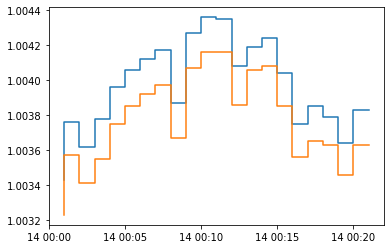

In [69]:
plt.step(df_trend["timestamp_utc.open"], df_trend["ask.open"])
plt.step(df_trend["timestamp_utc.open"], df_trend["bid.open"])

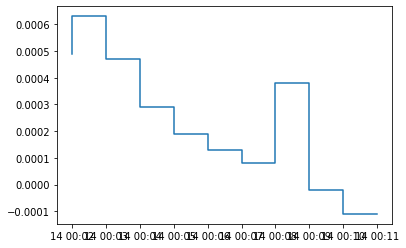

In [71]:
mask = df_trend["ema_up_profit"].notnull()
plt.step(df_trend.loc[mask, "timestamp_utc.open"], df_trend.loc[mask, "ema_up_profit"])